# Logistic regression using `scikit-learn`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm, metrics, model_selection as ms

Read in the [Wine Quality](https://archive.ics.uci.edu/ml/datasets/wine+quality) dataset.

In [2]:
wines = pd.read_csv("datasets/wine-quality.csv", sep=";")

Define a new variable 'good_quality' for wines with quality ≥ 7.

In [3]:
wines["good_quality"] = wines["quality"] >= 7

Fit a logistic regression model for 'good_quality' using all predictors.

In [4]:
X = wines.drop(columns=["quality", "good_quality"])
y = wines["good_quality"]

In [5]:
model = lm.LogisticRegression(C=1e50, solver="liblinear")
model.fit(X, y)

LogisticRegression(C=1e+50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Print variable names and odds ratios.

In [6]:
list(zip(X.columns, np.exp(model.coef_[0,:])))

[('fixed acidity', 1.085083004378137),
 ('volatile acidity', 0.01773967165103047),
 ('citric acid', 0.3744507000247129),
 ('residual sugar', 1.0639214110503994),
 ('chlorides', 0.01996820346417756),
 ('free sulfur dioxide', 1.0133071531751672),
 ('total sulfur dioxide', 0.9961872571138234),
 ('density', 0.00037462222208025823),
 ('pH', 3.878581621934436),
 ('sulphates', 3.5008118624161932),
 ('alcohol', 2.5343012721122675)]

Define 3 folds for stratified cross-validation.

In [7]:
cv = ms.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

Compute average classification accuracy across folds.

In [8]:
estimator = lm.LogisticRegression(C=1e50, solver="liblinear")
accuracies = ms.cross_val_score(estimator, X, y, scoring="accuracy", cv=cv)
np.mean(accuracies)

0.8031823245414037

Compute average AUC across folds.

In [9]:
aucs = ms.cross_val_score(estimator, X, y, scoring="roc_auc", cv=cv)
np.mean(aucs)

0.782870594390562

Determine 'optimal' value of `C` by cross-validation using AUC scoring and $L_{2}$ regularisation.

In [10]:
gs = ms.GridSearchCV(estimator,
                     param_grid={"C": np.logspace(-5, 5, 11)},
                     scoring="roc_auc",
                     cv=cv)
gs.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1e+50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [11]:
gs.best_score_

0.7843580529117674

In [12]:
gs.best_estimator_

LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

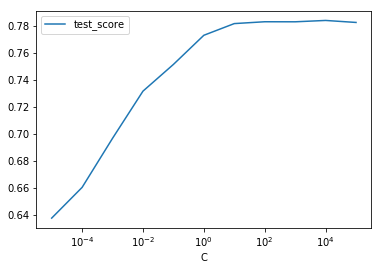

In [13]:
cv_results = pd.DataFrame({**gs.param_grid,
                           **{"test_score": gs.cv_results_["mean_test_score"]}})
cv_results.plot(x="C", y="test_score", logx=True)

Print variable names and odds ratios for the 'best' model.

In [14]:
list(zip(X.columns, np.exp(gs.best_estimator_.coef_[0,:])))

[('fixed acidity', 1.0774192073995388),
 ('volatile acidity', 0.018906463015764832),
 ('citric acid', 0.41119413979062047),
 ('residual sugar', 1.0626229933420597),
 ('chlorides', 2.9654900884346815e-07),
 ('free sulfur dioxide', 1.0129026373395564),
 ('total sulfur dioxide', 0.9966742828189387),
 ('density', 0.00032461658533034735),
 ('pH', 3.622166719084379),
 ('sulphates', 3.564886699331776),
 ('alcohol', 2.4068371045708825)]

Compute confusion matrix for the 'best' model.

In [15]:
metrics.confusion_matrix(y, gs.best_estimator_.predict(X))

array([[3653,  185],
       [ 781,  279]])

Plot the ROC curve for the 'best' model.

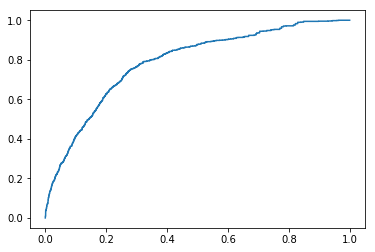

In [16]:
fpr, tpr, cutoffs = metrics.roc_curve(y, gs.best_estimator_.predict_proba(X)[:,1])
plt.plot(fpr, tpr)